In [2]:
import numpy as np
from matplotlib import pyplot as plt

from dftpy.ions import Ions
from dftpy.functional import Functional
from dftpy.formats import io

from ase.io import read
from ase.lattice.spacegroup import Spacegroup
from ase.lattice.spacegroup import crystal

from scipy.optimize import minimize

from dftpy.ions import Ions
from dftpy.functional import Functional
from dftpy.formats import io
from dftpy.ions import Ions
from dftpy.field import DirectField
from dftpy.grid import DirectGrid
from dftpy.functional import LocalPseudo, Functional, TotalFunctional, ExternalPotential
from dftpy.formats import io
from dftpy.math_utils import ecut2nr
from dftpy.optimization import Optimization

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ase/lattice/spacegroup.py:5: UserWarning: Moved to ase.spacegroup
  warnings.warn('Moved to ase.spacegroup')


In [3]:
path_pp='/Users/valeria/Documents/PP/ofpp/EAC/upf/blps/'
file='si.lda.upf'
PP_list = {'Si': path_pp+file}

In [4]:
KS_TE = []
for i in np.arange(0,30,1):
    with open('/Users/Valeria/Documents/aiWT/Model_ML_function/training_set_data/ks_calculations/Transition_Btin_HD/0.5/si_0.5_'+str(i)+'_4_Btin_hd.out') as D:
        k = [match for match in D if "!    total energy" in match]
    KS_te = str(k).split()[4]
    KS_TE.append(float(KS_te)) 
ks_te = np.asarray(KS_TE)

In [26]:
def min_energy(x0, *args):
        KS_TE, rho, ions = args
        nr = rho.grid.nr
        rho *= 16.0/rho.integral()
        KE = Functional(type='KEDF',name='WT', rho0=x0)
        grid = DirectGrid(lattice=ions.cell, nr=[nr[0], nr[1], nr[2]])
        print(grid)
        PSEUDO = LocalPseudo(grid = grid, ions=ions, PP_list=PP_list, rcut=10)
        # rho_ini = DirectField(grid=grid)
        # rho_ini[:] = ions.get_ncharges()/ions.cell.volume
        
        evaluator = TotalFunctional(KE=KE, XC=XC, HARTREE=HARTREE, PSEUDO=PSEUDO)
        # optimization_options = {'econv' : 1e-5*ions.nat}
        # opt = Optimization(EnergyEvaluator=evaluator, optimization_options = optimization_options, 
        #                    optimization_method = 'TN')
        # rho = opt.optimize_rho(guess_rho=rho_ini)
        # 
        OF_TE = evaluator.Energy(rho=rho, ions=ions)
        # OF_KE = KE(rho).energy
        diff = np.abs(KS_TE*1/2-OF_TE)
        print(diff)
        return diff

In [20]:
rho = io.read_density('/Users/valeria/Documents/aiWT/Model_ML_function/training_set_data/ks_calculations/Transition_Btin_HD/0.5/si_0.5_1_4_Btin_hd.xsf')
rho.grid.nr

array([36, 32, 36])

In [23]:
XC = Functional(type='XC',name='LDA')
HARTREE = Functional(type='HARTREE')
delta_E = []
R0 = []
vol = []
for n in np.arange(0,30,1):
    print('NEW STRUCTURE')
    i = int(n)
    rho = io.read_density('/Users/valeria/Documents/aiWT/Model_ML_function/training_set_data/ks_calculations/Transition_Btin_HD/0.5/si_0.5_'+str(i)+'_4_Btin_hd.xsf')
    ions = Ions.from_ase(read('/Users/valeria/Documents/aiWT/Model_ML_function/training_set_data/ks_calculations/Transition_Btin_HD/0.5/si_0.5_'+str(i)+'_4_Btin_hd.in'))
    KS_TE = ks_te[i]
    minn = minimize(min_energy, 0.02, args = (KS_TE, rho, ions), method='Powell', bounds=[[0.01,0.07]], options={'ftol' : 1e-6})
    VOLUME = ions.get_volume()
    vol.append(VOLUME)
    delta_E.append(minn.fun)
    R0.append(minn.x)

NEW STRUCTURE
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
0.20862698571833072
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
0.11010803250333723
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
0.06516774345453591
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
0.0291274891916391
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
0.0025375660014805845
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
0.012492850872639849
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
0.0023844752112438528
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
0.0020394508541343725
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
0.006080465582082084
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
4.54090554669051e-06
setting key: Si ->

Text(0, 0.5, '$ρ_{0}$')

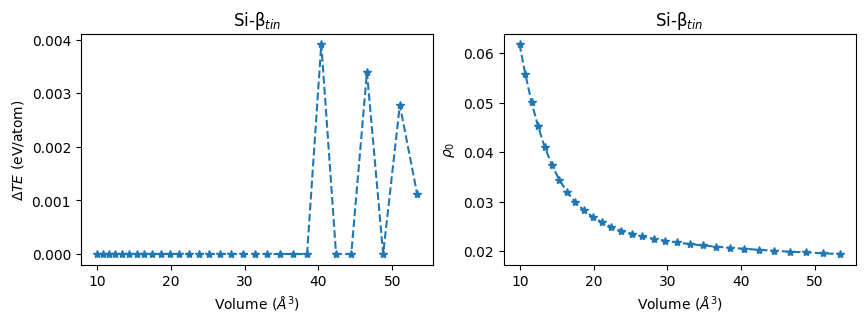

In [27]:
fig, axs = plt.subplots(1,2, figsize=(10,3))
im0 = axs[0].plot(np.asarray(vol)*0.529177**3/4,np.asarray(delta_E)*27.211407/4,'*--')
im1 = axs[1].plot(np.asarray(vol)*0.529177**3/4,np.asarray(R0),'*--')
axs[0].set_title('Si-\u03B2$_{tin}$')
axs[1].set_title('Si-\u03B2$_{tin}$')
axs[0].set_xlabel('Volume ($\AA^{3}$)')
axs[0].set_ylabel('$\Delta TE$ (eV/atom)')
axs[1].set_xlabel('Volume ($\AA^{3}$)')
axs[1].set_ylabel('$\u03C1_{0}$')

In [25]:
np.save('/Users/Valeria/Documents/aiWT/Model_ML_function/training_set_data/ks_calculations/Transition_Btin_HD/DATA2/rho0_dTE', R0)

In [22]:
rho0_Btin_hd=np.load("/Users/Valeria/Documents/aiWT/Model_ML_function/training_set_data/ks_calculations/Transition_Btin_HD/DATA2/rho0.npy")
rho0_Btin_hd

array([[0.06183619],
       [0.05569476],
       [0.05016426],
       [0.04526297],
       [0.04101923],
       [0.03739676],
       [0.03442037],
       [0.03196953],
       [0.02996774],
       [0.02830957],
       [0.02695852],
       [0.02580776],
       [0.02491722],
       [0.02415523],
       [0.02353096],
       [0.02298873],
       [0.02253518],
       [0.02211014],
       [0.02173723],
       [0.02144376],
       [0.02116879],
       [0.02091148],
       [0.02068172],
       [0.02047127],
       [0.02028783],
       [0.02008376],
       [0.01991888],
       [0.01974517],
       [0.01958934],
       [0.01942135]])